# Advanced Exploratory Data Analysis: MOBIE Datasets
This notebook performs hierarchical analysis, pricing segmentation, and geospatial mapping for EV charging stations in Portugal.

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
try:
    import geopandas as gpd
    from shapely.geometry import Point
    import duckdb
    HAS_GEOPANDAS = True
except ImportError:
    HAS_GEOPANDAS = False

# Set plot style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [62]:
DATA_DIR = '../../data'
POSTOS_FILE = os.path.join(DATA_DIR, 'MOBIe_Lista_de_postos_corrected.csv')
TARIFAS_FILE = os.path.join(DATA_DIR, 'MOBIE_Tarifas.csv')
MAP_PATH = os.path.join(DATA_DIR, 'GRID1K21_CONT.gpkg')
OSM_DB_PATH = os.path.join(DATA_DIR, 'osm_analysis.db')

In [63]:
# Load datasets
df_postos = pd.read_csv(POSTOS_FILE, sep=';', encoding='utf-8-sig')
df_tarifas = pd.read_csv(TARIFAS_FILE, sep=';', encoding='utf-8-sig')

# Clean power column (convert comma to dot if string)
def clean_power(val):
    if isinstance(val, str):
        return float(val.replace(',', '.'))
    return val

df_postos['POTÊNCIA DA TOMADA (kW)'] = df_postos['POTÊNCIA DA TOMADA (kW)'].apply(clean_power)

print('Datasets loaded successfully.')

Datasets loaded successfully.


## 1. Station-Charger Hierarchy
Analyzing the distribution of chargers per station and their characteristics.

/tmp/ipykernel_201994/3680511337.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=chargers_per_station, x='Charger Count', palette='Blues_d')


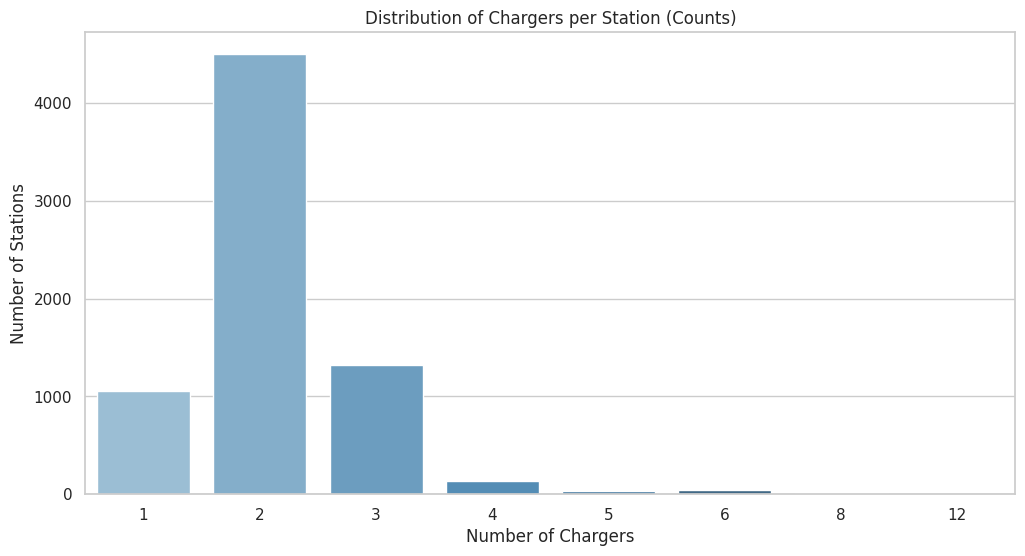

Max chargers in a single station: 12
Average chargers per station: 2.13


In [64]:
# Chargers per Station
chargers_per_station = df_postos.groupby('ID')['UID DA TOMADA'].count().reset_index()
chargers_per_station.columns = ['Station ID', 'Charger Count']

plt.figure(figsize=(12, 6))
# Using countplot for discrete data to avoid KDE issues with integers
sns.countplot(data=chargers_per_station, x='Charger Count', palette='Blues_d')
plt.title('Distribution of Chargers per Station (Counts)')
plt.xlabel('Number of Chargers')
plt.ylabel('Number of Stations')
plt.show()

print(f'Max chargers in a single station: {chargers_per_station["Charger Count"].max()}')
print(f'Average chargers per station: {chargers_per_station["Charger Count"].mean():.2f}')

,TIPO DE TOMADA,FORMATO DA TOMADA,count
6,Mennekes,SOCKET,7788
0,CCS,CABLE,4058
2,CHAdeMO,CABLE,1699
5,Mennekes,CABLE,1504
4,Industrial,SOCKET,36
1,CCS,SOCKET,7
3,CHAdeMO,SOCKET,2


/tmp/ipykernel_201994/369444472.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_postos, x='TIPO DE TOMADA', y='POTÊNCIA DA TOMADA (kW)', palette='muted')


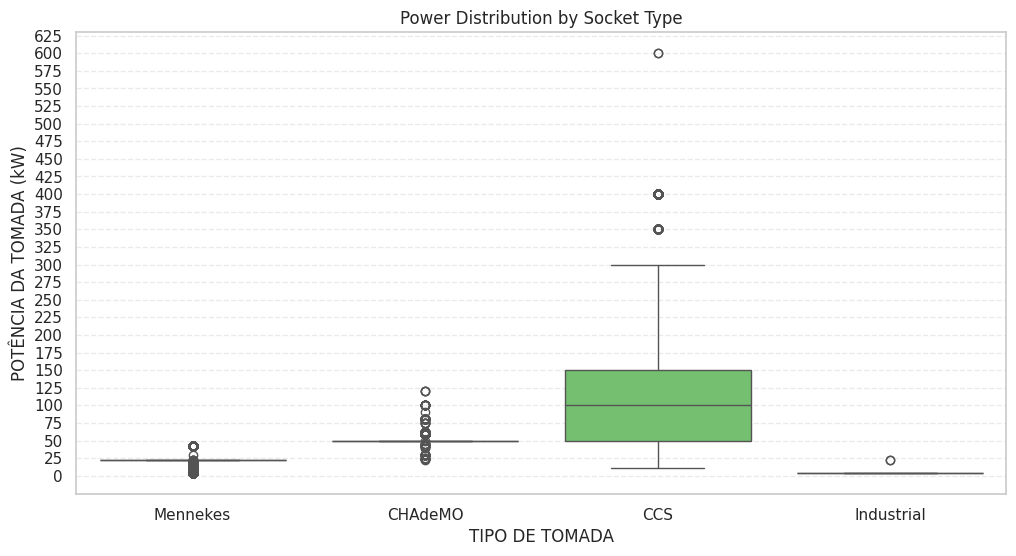

In [65]:
# Segmentation by Socket Type and Power
socket_power = df_postos.groupby(['TIPO DE TOMADA', 'FORMATO DA TOMADA']).size().reset_index(name='count')
display(socket_power.sort_values('count', ascending=False))

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_postos, x='TIPO DE TOMADA', y='POTÊNCIA DA TOMADA (kW)', palette='muted')
plt.title('Power Distribution by Socket Type')
plt.xticks(rotation=0)

# Increase Y-axis granularity for better visibility
max_p = df_postos['POTÊNCIA DA TOMADA (kW)'].max()
plt.yticks(np.arange(0, max_p + 50, 25))
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.show()

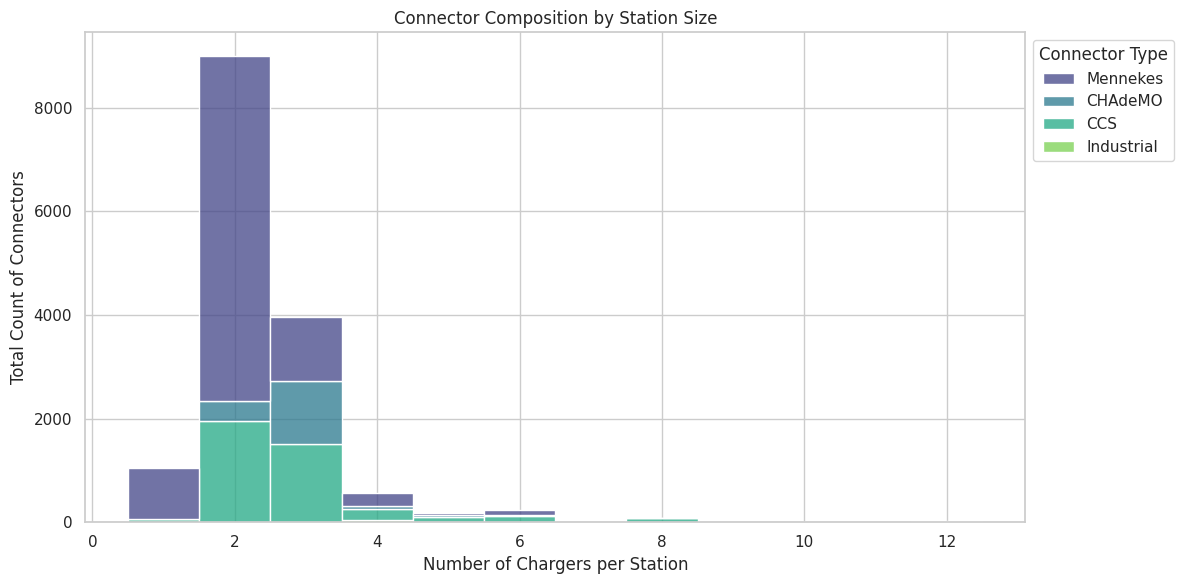

In [66]:
# Connector Composition by Station Size
station_sizes = df_postos.groupby('ID')['UID DA TOMADA'].count().reset_index()
station_sizes.columns = ['ID', 'Station Size']
df_merged = df_postos.merge(station_sizes, on='ID')

plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df_merged, x='Station Size', hue='TIPO DE TOMADA', 
                  multiple='stack', discrete=True, palette='viridis')
plt.title('Connector Composition by Station Size')
plt.xlabel('Number of Chargers per Station')
plt.ylabel('Total Count of Connectors')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), title='Connector Type')
plt.tight_layout()
plt.show()

## 2. Pricing Segmentation
Extracting numeric tariffs and analyzing by tariff type.

In [67]:
def extract_price(tarifa_str):
    if pd.isna(tarifa_str): return np.nan
    # Find patterns like € 0.261 or 0,1
    match = re.search(r'(\d+[.,]\d+)', str(tarifa_str))
    if match:
        return float(match.group(1).replace(',', '.'))
    return np.nan

df_tarifas['tarifa_num'] = df_tarifas['TARIFA'].apply(extract_price)

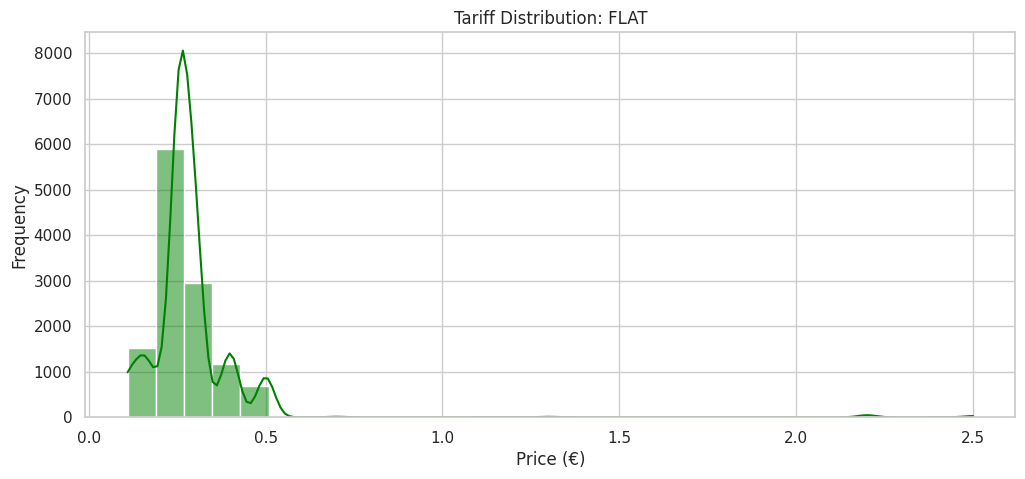

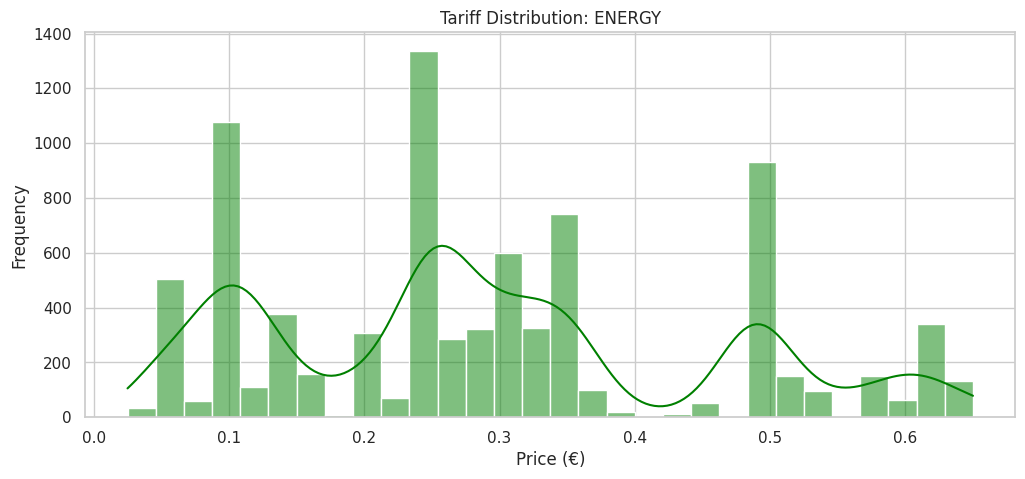

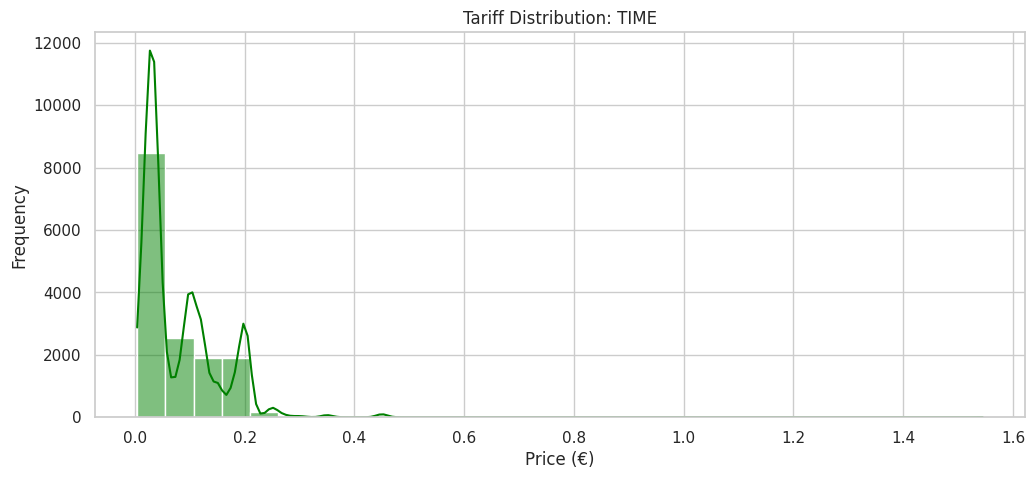

In [68]:
for t_type in df_tarifas['TIPO_TARIFA'].unique():
    subset = df_tarifas[df_tarifas['TIPO_TARIFA'] == t_type].dropna(subset=['tarifa_num'])
    if len(subset) == 0: continue
    
    plt.figure(figsize=(12, 5))
    # Standard distribution plot with KDE for better visibility of trends
    sns.histplot(subset['tarifa_num'], kde=True, bins=30, color='green')
    plt.title(f'Tariff Distribution: {t_type}')
    plt.xlabel('Price (€)')
    plt.ylabel('Frequency')
    plt.show()

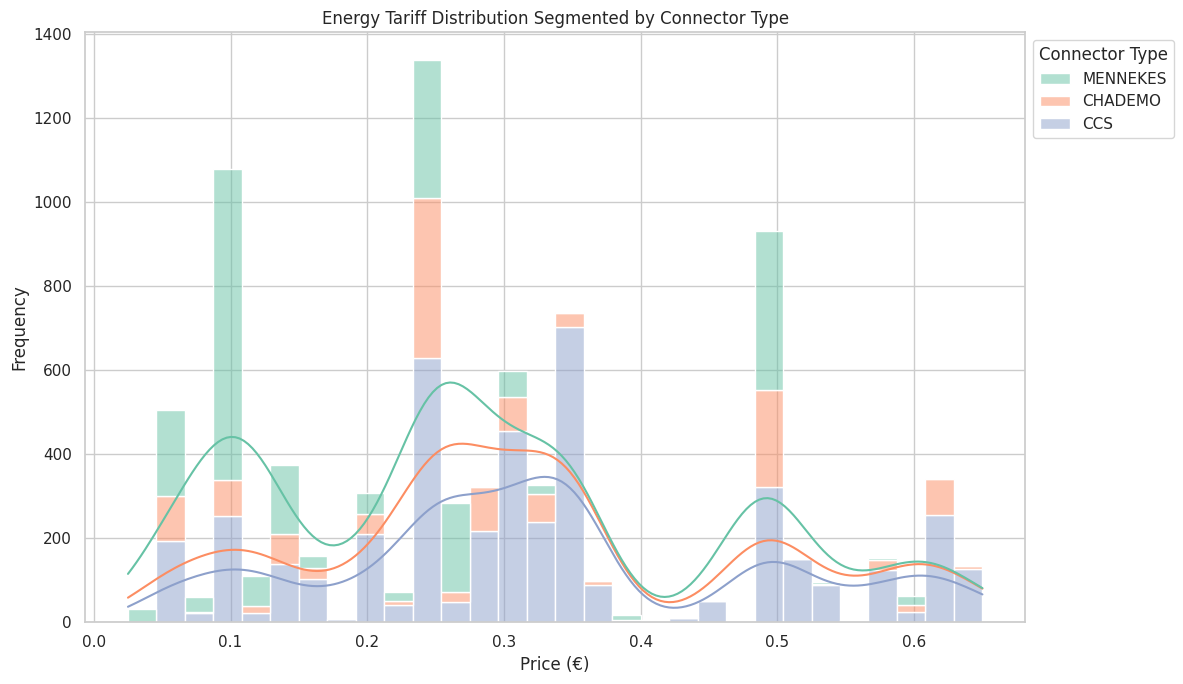

In [69]:
# Segmented Energy Tariff by Connector Type
energy_subset = df_tarifas[df_tarifas['TIPO_TARIFA'] == 'ENERGY'].dropna(subset=['tarifa_num'])
if len(energy_subset) > 0:
    plt.figure(figsize=(12, 7))
    ax = sns.histplot(data=energy_subset, x='tarifa_num', hue='TIPO_TOMADA', 
                      kde=True, multiple='stack', bins=30, palette='Set2')
    plt.title('Energy Tariff Distribution Segmented by Connector Type')
    plt.xlabel('Price (€)')
    plt.ylabel('Frequency')
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), title='Connector Type')
    plt.tight_layout()
    plt.show()

## 3. Geospatial Mapping
Integrated visualization of charging stations and road networks.

### 3.1 National Highway Network

Fetching comprehensive road network...


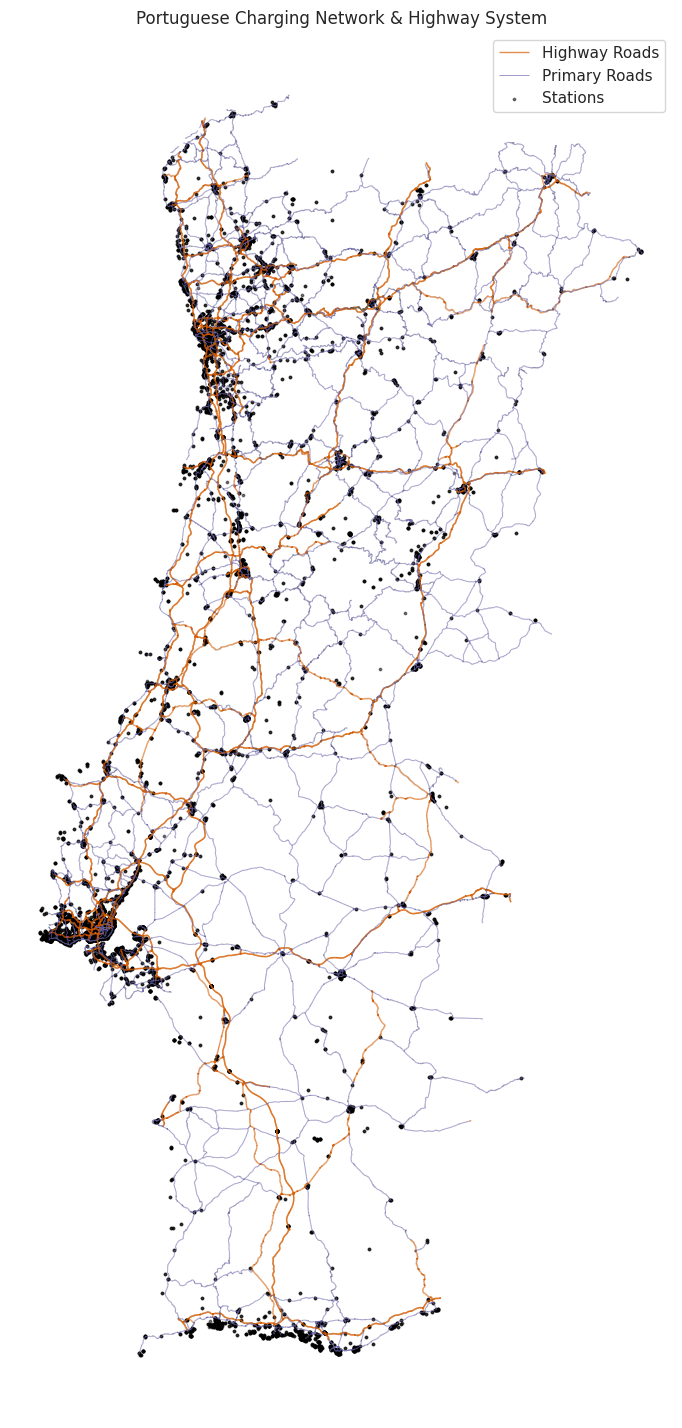

In [70]:
# Advanced Mapping with Classification
if HAS_GEOPANDAS:
    # 1. Create Station GeoDataFrame (EPSG:4326 -> EPSG:3763)
    gdf_stations = gpd.GeoDataFrame(df_postos, geometry=gpd.points_from_xy(df_postos.LONGITUDE, df_postos.LATITUDE))
    gdf_stations.crs = 'EPSG:4326'
    gdf_stations = gdf_stations.to_crs('EPSG:3763')
    
    # 2. Fetch Broad Road Network with Links
    print('Fetching comprehensive road network...')
    all_roads = gpd.GeoDataFrame()
    try:
        con = duckdb.connect(OSM_DB_PATH, read_only=True)
        con.execute('INSTALL spatial; LOAD spatial;')
        
        if 'roads_global' in [t[0] for t in con.execute('SHOW TABLES').fetchall()]:
             # Expanded query to include links and tertiary roads for detail
             # We map them to simpler categories for plotting
             target_types = [
                 'motorway', 'motorway_link', 
                 'trunk', 'trunk_link', 
                 'primary', 'primary_link',
                 'secondary', 'secondary_link',
                 'tertiary', 'tertiary_link',
                 'residential', 'unclassified', 'living_street',
                 'service', 'pedestrian', 'footway', 'track', 'path', 'cycleway'
             ]
             formatted_types = ", ".join([f"'{t}'" for t in target_types])
             
             query = f"SELECT highway, ST_AsWKB(geometry) as geometry FROM roads_global WHERE highway IN ({formatted_types})"
             
             df_roads = con.execute(query).fetchdf()
             if not df_roads.empty:
                 df_roads['geometry'] = gpd.GeoSeries.from_wkb(df_roads['geometry'].apply(bytes))
                 raw_roads = gpd.GeoDataFrame(df_roads, geometry='geometry', crs='EPSG:3035')
                 all_roads = raw_roads.to_crs('EPSG:3763')
                 
                 # Create simplified 'Road Class' for coloring
                 def classify_road(h):
                     if 'motorway' in h or 'trunk' in h: return 'Highway' # Fast
                     if 'primary' in h: return 'Primary' # Main
                     if 'secondary' in h: return 'Secondary'
                     return 'Local'
                 all_roads['road_class'] = all_roads['highway'].apply(classify_road)

    except Exception as e:
        print(f'DB Error: {e}')
    

    # --- PLOT 1: National Overview (Highways Only) ---
    fig, ax = plt.subplots(figsize=(12, 18))
    
    # Define color scheme for importance
    road_colors = {'Highway': '#d95f02', 'Primary': '#7570b3', 'Secondary': '#999999', 'Local': '#d9d9d9'}
    road_widths = {'Highway': 1.0, 'Primary': 0.7, 'Secondary': 0.5, 'Local': 0.3}
    
    if not all_roads.empty:
        # Plot National Backbone (Highways + Primary)
        national_roads = all_roads[all_roads['road_class'].isin(['Highway', 'Primary'])]
        
        # Plot by category for legend
        for rtype in ['Highway', 'Primary']:
            subset = national_roads[national_roads['road_class'] == rtype]
            if not subset.empty:
                subset.plot(ax=ax, color=road_colors[rtype], linewidth=road_widths[rtype], label=f'{rtype} Roads', alpha=0.7)

    gdf_stations.plot(ax=ax, markersize=3, color='black', alpha=0.5, label='Stations')
    
    plt.title('Portuguese Charging Network & Highway System')
    plt.axis('off')
    plt.legend(loc='upper right')
    plt.show()
    

    # --- HELPER FUNCTION: City Zoom ---
    def plot_city_context(city_name, color_column=None, title_suffix=''):
        city_stations = gdf_stations[gdf_stations['CIDADE'] == city_name]
        if city_stations.empty: return
        
        minx, miny, maxx, maxy = city_stations.total_bounds
        buff = 2500 # 2.5km buffer
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot Roads (All types relevant for city)
        if not all_roads.empty:
            try:
                local_roads = all_roads.cx[minx-buff:maxx+buff, miny-buff:maxy+buff]
                if not local_roads.empty:
                     for rtype in ['Highway', 'Primary', 'Secondary', 'Local']:
                         subset = local_roads[local_roads['road_class'] == rtype]
                         if not subset.empty:
                            subset.plot(ax=ax, color=road_colors.get(rtype, 'grey'), 
                                      linewidth=road_widths.get(rtype, 0.5), alpha=0.6, zorder=1)
            except: pass
        
        # Plot Stations
        if color_column:
            # Categorical Plot
            city_stations.plot(ax=ax, column=color_column, markersize=35, 
                             legend=True, cmap='viridis', zorder=2, alpha=0.9)
        else:
            # Simple Plot
            city_stations.plot(ax=ax, color='red', markersize=35, label='Stations', zorder=2)
            
        plt.title(f'{city_name}: {title_suffix}')
        plt.xlim(minx-buff, maxx+buff)
        plt.ylim(miny-buff, maxy+buff)
        plt.axis('off')
        plt.show()
    
    top_cities = df_postos['CIDADE'].value_counts().head(3).index.tolist()
else:
    print('Geopandas required')
    top_cities = []

### 3.2 Network Density by City
Zoomed views showing station placement relative to local road infrastructure.

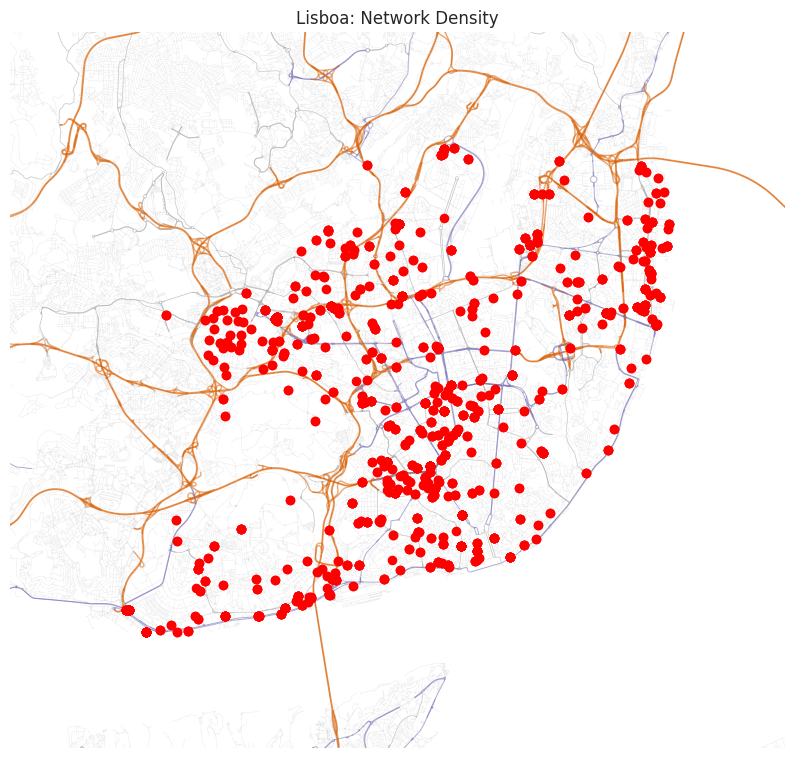

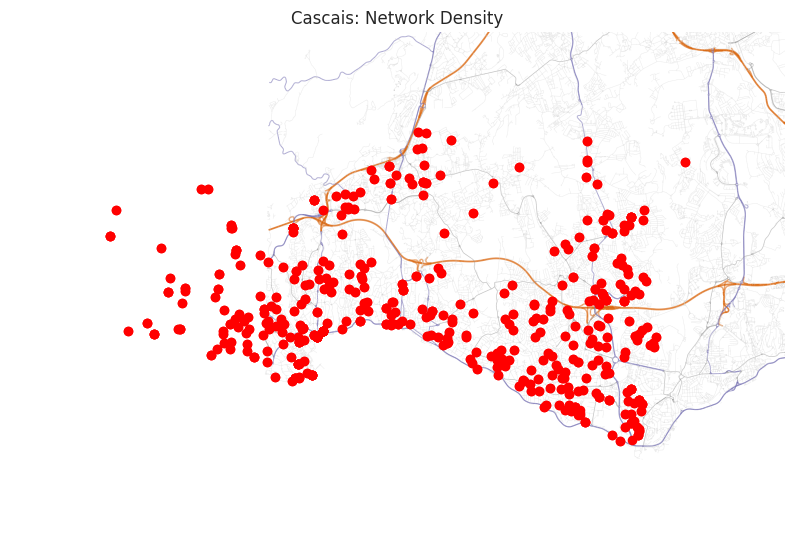

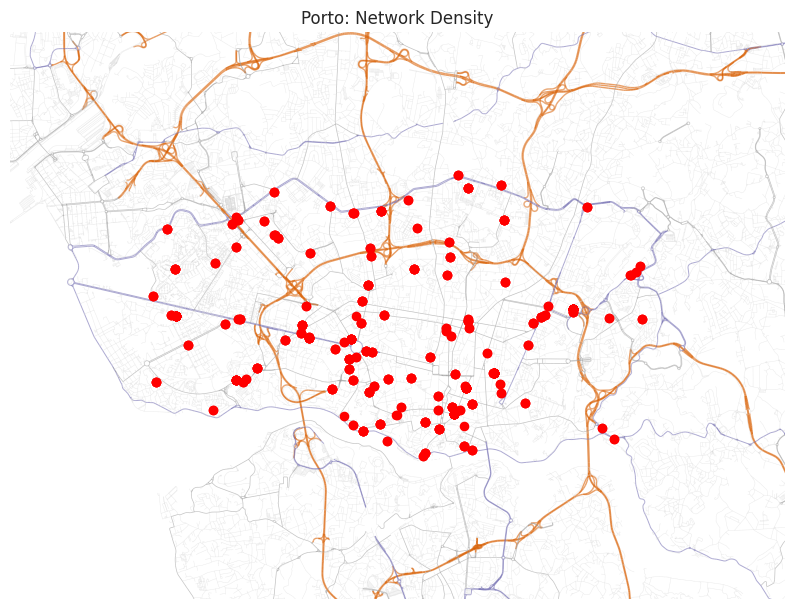

In [71]:
# Plot Basic City Zooms
if HAS_GEOPANDAS:
    for city in top_cities:
        plot_city_context(city, title_suffix='Network Density')

### 3.3 Charging Types by City
Distribution of charging categories (TIPO DE CARREGAMENTO) within major urban centers.

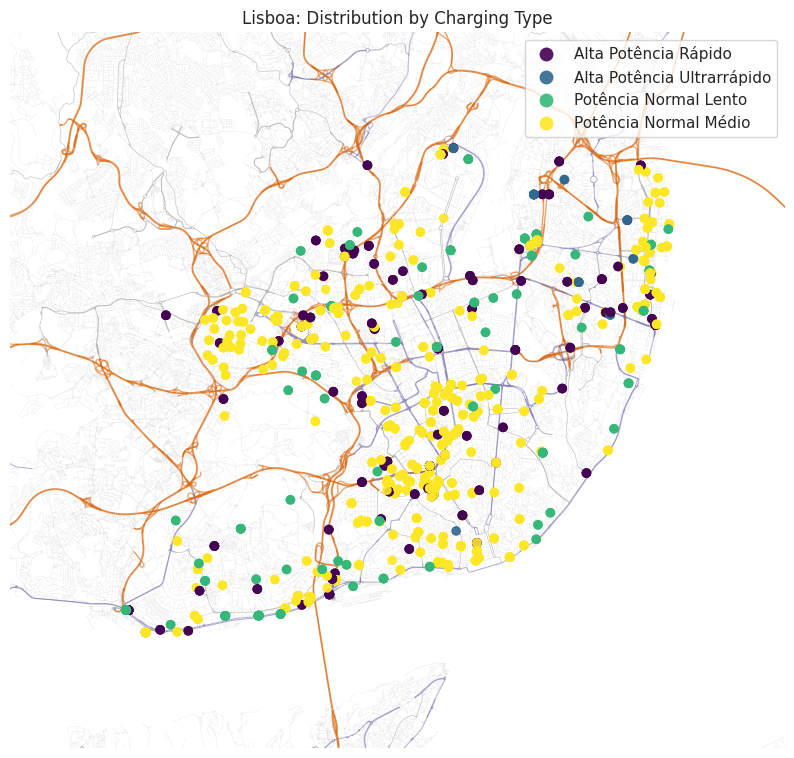

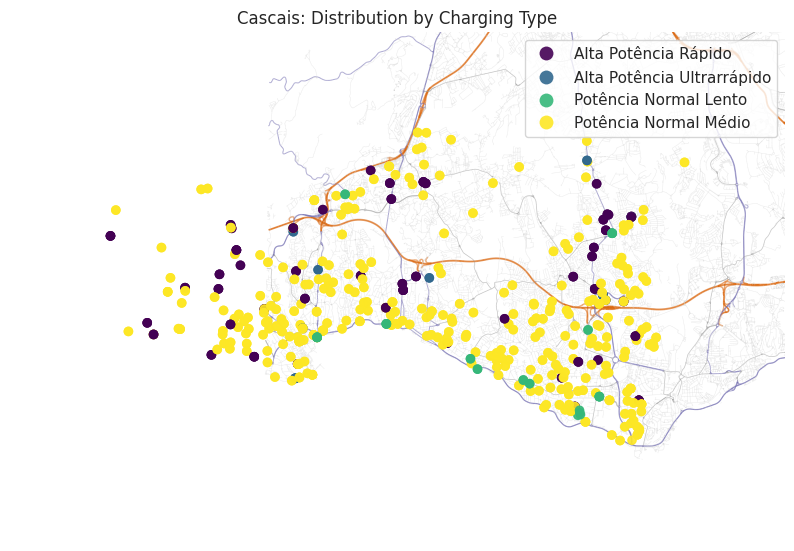

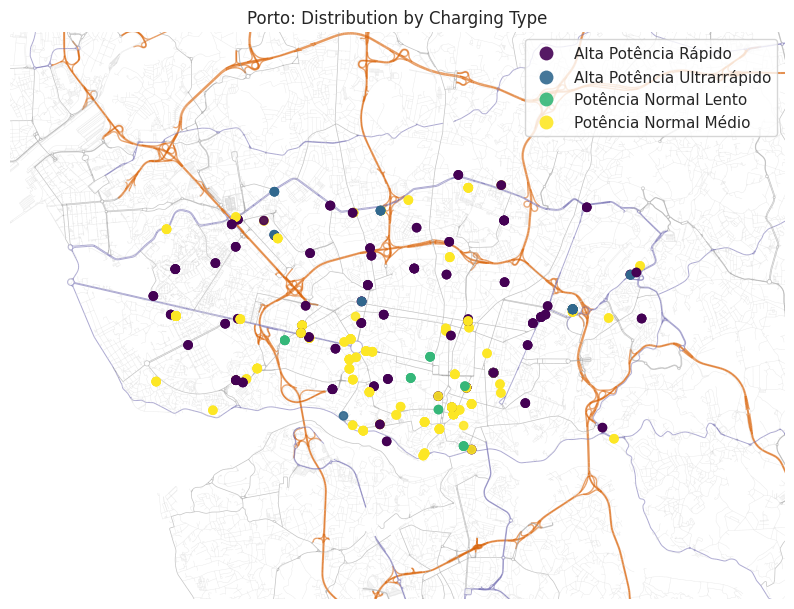

In [72]:
# Plot Charging Type Distribution
if HAS_GEOPANDAS:
    for city in top_cities:
        plot_city_context(city, color_column='TIPO DE CARREGAMENTO', 
                         title_suffix='Distribution by Charging Type')